# Download data

In [5]:
import os
import zipfile
import kaggle
# use kaggle api to download the data or manully download the data urself
## ! Kaggle competitions download -c "jane-street-real-time-market-data-forecasting" 

# make the directory to be "data/jane-street-real-time-market-data-forecasting" and extract file there u f the code dont work do it manually
## os.makedirs("data/jane-street-real-time-market-data-forecasting", exist_ok=True) # create directory for jane-street-real-time-market-data-forecasting-housing
## !unzip jane-street-real-time-market-data-forecasting.zip -d data/jane-street-real-time-market-data-forecasting/

# Kaggle Competition 

In [105]:
import numpy as np
import pandas as pd
import polars as pl
from sklearn.metrics import r2_score
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler


In [7]:
# function for import the data .parquet to pandas dataframe
def download_data(i): # the data have 10 partiton 0 to 9
    file_path = f"data/jane-street-real-time-market-data-forecasting/train.parquet/partition_id={i}/part-0.parquet"
    df = pd.read_parquet(file_path)
    print(f"import train data part {i}")
    return df

In [8]:
# test/example of the import fuction
# train0 = download_data(0)
train9 = download_data(9) # there are just more data in the train.parquet partition 9

import train data part 9


In [9]:
# import test data 
file_path  = f"data/jane-street-real-time-market-data-forecasting/test.parquet/date_id=0/part-0.parquet"
test = pd.read_parquet(file_path)

# Data Preprocessing

In [10]:
train9.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,1530,0,0,3.084694,1.153571,1.563784,0.697396,0.756759,2.580965,0.171311,...,0.999516,0.417462,0.323897,0.601499,2.074103,0.746552,0.552013,3.071231,0.914794,0.997124
1,1530,0,1,2.232906,0.553354,1.730064,0.990195,0.611490,2.023031,0.319015,...,0.160609,-0.318671,-0.399384,-0.635306,2.092151,0.342582,0.757289,1.979042,0.967537,1.219739
2,1530,0,2,2.404948,1.532503,2.095852,0.919688,0.583715,2.330047,0.337096,...,-0.065761,0.200878,-0.006571,0.518870,-0.344441,0.641694,-0.646040,-0.506260,0.739797,-2.041514
3,1530,0,3,1.986533,0.647099,1.687460,0.569406,1.061679,2.444131,0.150487,...,0.526284,-0.349773,-0.235901,-0.428956,-1.903627,-1.214619,-0.469500,-2.590589,-0.946317,-0.390001
4,1530,0,4,2.742601,1.096778,1.551411,0.632113,0.368218,2.181873,0.214604,...,-0.965623,-0.373938,-0.209282,-0.095182,-1.598217,0.968505,-0.705594,-1.579623,0.954296,-1.805623


In [11]:
#check test data
test.head()

,row_id,date_id,time_id,symbol_id,weight,is_scored,feature_00,feature_01,feature_02,feature_03,...,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,0,0,0,0,3.169998,True,0.0,0.0,0.0,0.0,...,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
1,1,0,0,1,2.165993,True,0.0,-0.0,0.0,0.0,...,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0
2,2,0,0,2,3.065550,True,0.0,-0.0,0.0,0.0,...,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
3,3,0,0,3,2.698642,True,0.0,0.0,0.0,0.0,...,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
4,4,0,0,4,1.803330,True,0.0,-0.0,0.0,0.0,...,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0


## Data cleaning

In [12]:
# feature selection ## select every feature except 0-4 
feature_cols = [f"feature_{idx:02d}" for idx in range(79)]
train9[feature_cols]

#select target values
target_cols = ["responder_6"]
train9[target_cols]

#select lag values
time_cols = ["date_id","time_id"]
train9[time_cols]



,date_id,time_id
0,1530,0
1,1530,0
2,1530,0
3,1530,0
4,1530,0
...,...,...
6274571,1698,967
6274572,1698,967
6274573,1698,967
6274574,1698,967


## drop the other responder column

In [13]:
drop_col = [f"responder_{idx}"for idx in range(6)] + [f"responder_{idx}"for idx in range(7,9)]
train9 = train9.drop(columns= drop_col , axis= 1, errors= 'ignore')
train9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6274576 entries, 0 to 6274575
Data columns (total 84 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date_id      int16  
 1   time_id      int16  
 2   symbol_id    int8   
 3   weight       float32
 4   feature_00   float32
 5   feature_01   float32
 6   feature_02   float32
 7   feature_03   float32
 8   feature_04   float32
 9   feature_05   float32
 10  feature_06   float32
 11  feature_07   float32
 12  feature_08   float32
 13  feature_09   int8   
 14  feature_10   int8   
 15  feature_11   int16  
 16  feature_12   float32
 17  feature_13   float32
 18  feature_14   float32
 19  feature_15   float32
 20  feature_16   float32
 21  feature_17   float32
 22  feature_18   float32
 23  feature_19   float32
 24  feature_20   float32
 25  feature_21   float32
 26  feature_22   float32
 27  feature_23   float32
 28  feature_24   float32
 29  feature_25   float32
 30  feature_26   float32
 31  feature_27   float32
 32

# split the data and transfrom them into ts 

In [ ]:
# create the X and Y data
def createXY(dataset,n_past):
    # n_past is the number of past tine data we want to use to predict the future
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

In [136]:
## i should make the scalar transformation  outside the function
# preprocess the data
def preprocessdata(df, sym_id,n_past) : # sym_id is the symbol_id of the data we want to preprocess (1-30)
    ts = df[df.symbol_id == sym_id]  
    ts = ts.drop("symbol_id",  axis = 1 , errors= "ignore") # drop the column sincce it useless in model trainng 

    # Sort the DataFrame by date_id and time_id to ensure consistent ordering
    ts = ts.sort_values(by=['date_id', 'time_id']).reset_index(drop=True)

    # Create a unique integer label in order
    ts['label'] = range(1, len(ts) + 1)

    ts.fillna(ts.mean(), inplace=True) # fill the missing value with the mean value of the column

    # split the data
    test_split=round(len(ts)*0.20)
    ts_train = ts[:-test_split]
    ts_test = ts[-test_split:]

    scaler = MinMaxScaler(feature_range=(-1, 1))

    ts_train_scaled = scaler.fit_transform(ts_train[feature_cols +target_cols])
    ts_test_scaled = scaler.transform(ts_test[feature_cols + target_cols])
    
    X_train, y_train = createXY(ts_train_scaled,n_past) # create the X and Y data for training
    X_test, y_test = createXY(ts_test_scaled,n_past) # create the X and Y data for testing

    return X_train, y_train, X_test, y_test


# model 1 for symbol_id 1 LSTM

## model

In [153]:
n_past = 10
X1_train, y1_train, X1_test, y1_test = preprocessdata(train9, 1,n_past)

In [154]:
# Define the model architecture
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_past, 80)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Generate dummy data for demonstration
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(X1_train, y1_train, epochs=10)



c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.0109
Epoch 2/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.0065
Epoch 3/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.0063
Epoch 4/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0062
Epoch 5/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0061
Epoch 6/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0060
Epoch 7/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0059
Epoch 8/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0059
Epoch 9/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0059
Epoch 10/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0059


In [155]:
y_pred = model.predict(X1_test)
r2 = r2_score(y1_test, y_pred)
print(f'R^2 Score: {r2}')

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
R^2 Score: 0.9482687711715698


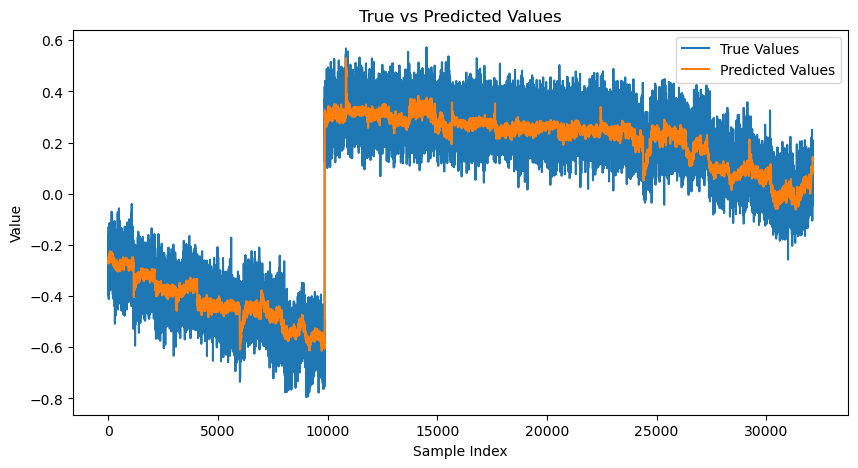

In [156]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(y1_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

## test model with other symbol_id

In [157]:
X2_train, y2_train, X2_test, y2_test = preprocessdata(train9, 2,n_past)

In [158]:
y_pred = model.predict(X2_test)
r2 = r2_score(y2_test, y_pred)
print(f'R^2 Score: {r2}') 

1017/1017 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
R^2 Score: 0.9388037323951721


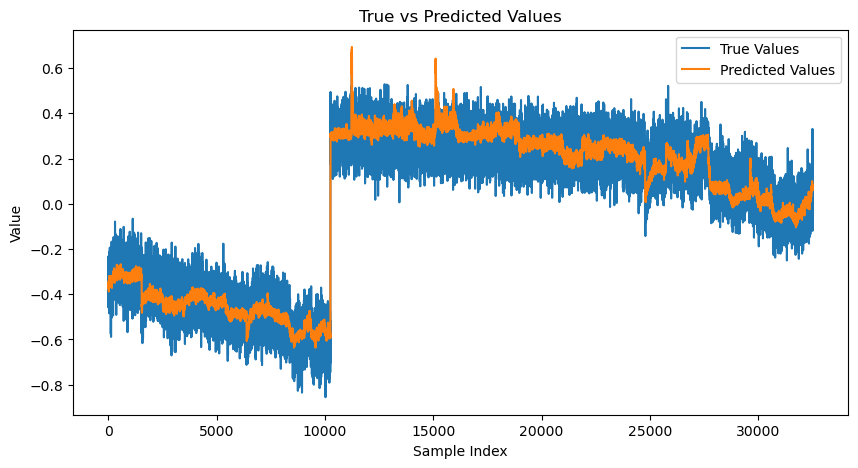

In [159]:
plt.figure(figsize=(10, 5))
plt.plot(y2_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [160]:
X3_train, y3_train, X3_test, y3_test = preprocessdata(train9, 3,n_past)

In [161]:
y_pred = model.predict(X3_test)
r2 = r2_score(y3_test, y_pred)
print(f'R^2 Score: {r2}') 

1011/1011 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
R^2 Score: 0.9416506290435791


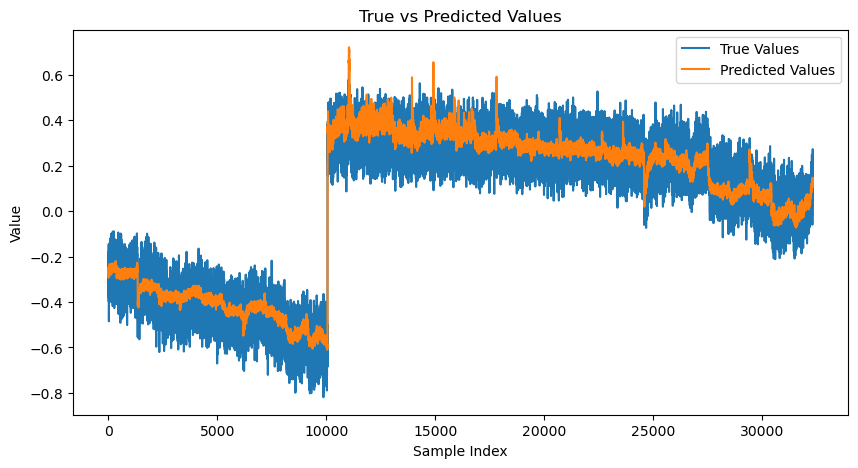

In [162]:
plt.figure(figsize=(10, 5))
plt.plot(y3_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [163]:
X4_train, y4_train, X4_test, y4_test = preprocessdata(train9, 4,n_past)

In [164]:
y_pred = model.predict(X4_test)
r2 = r2_score(y4_test, y_pred)
print(f'R^2 Score: {r2}') 

944/944 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
R^2 Score: 0.097353994846344


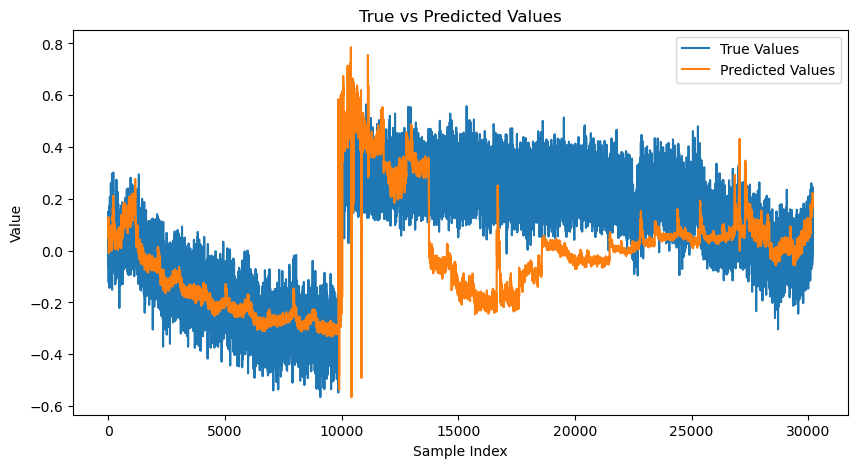

In [165]:
plt.figure(figsize=(10, 5))
plt.plot(y4_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [166]:
X30_train, y30_train, X30_test, y30_test = preprocessdata(train9, 30,n_past)

In [167]:
y_pred = model.predict(X30_test)
r2 = r2_score(y30_test, y_pred)
print(f'R^2 Score: {r2}') 

1017/1017 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
R^2 Score: 0.9495443105697632


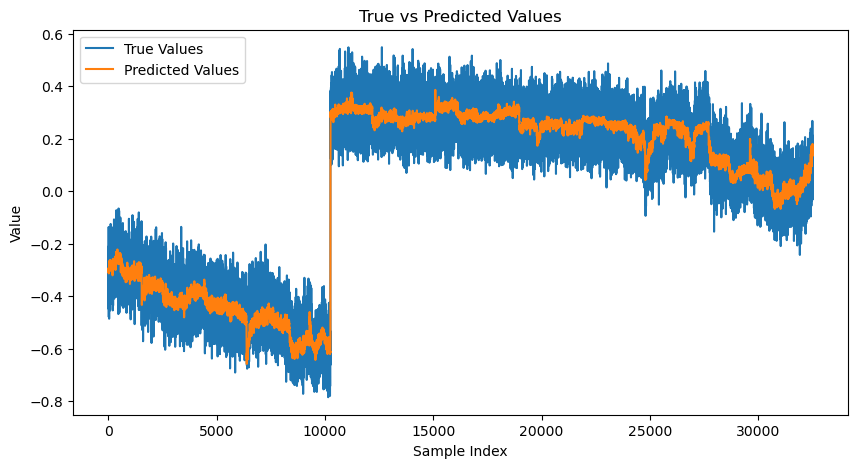

In [168]:
plt.figure(figsize=(10, 5))
plt.plot(y30_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()